In [63]:
import os
import tarfile
import shutil
import hashlib
import glob
import random
import pickle
from datetime import datetime
from typing import *
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import cv2
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
import random
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from HorizontalFeature2 import HorizontalFeature2
from VerticalFeature2 import VerticalFeature2
from HorizontalFeature3 import HorizontalFeature3
from VerticalFeature3 import VerticalFeature3
from DiagonalFeature import DiagonalFeature



In [64]:
def display(img, cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap='gray')

In [65]:
def toIntegral (img):
    integral = np.cumsum(np.cumsum(img, axis=0), axis=1)
    return np.pad(integral, (1, 1), 'constant', constant_values=(0, 0))[:-1, :-1]


In [66]:
arr = np.array([[5,2,3,4,1],[1,5,4,2,3],[2,2,1,3,4],[3,5,6,4,5],[4,1,3,2,6]])
integral = toIntegral(arr)

print (integral)

[[ 0  0  0  0  0  0]
 [ 0  5  7 10 14 15]
 [ 0  6 13 20 26 30]
 [ 0  8 17 25 34 42]
 [ 0 11 25 39 52 65]
 [ 0 15 30 47 62 81]]


In [67]:
def getRegionSum (integral, x, y, width, height):
    return (integral[y + height -1][x + width -1] + integral[y -1][x - 1] - integral[y - 1][x + width - 1] - integral[y + height -1][x - 1] )

In [68]:
#                            x      y      w  h
sum = getRegionSum(integral, 0 + 1, 0 + 1, 5, 5)
print (sum)

81


In [69]:
WINDOW_SIZE = 15

In [70]:
dataset_path = 'dataset'
if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)

In [71]:
def gammaCorrection(img, coeff):
    return img**(1./coeff)

In [72]:
def to_float_array(img):
    return np.array(img).astype(np.float32) / 255.

In [73]:
def preProcessing(imgPath, resize = True):
    img = cv2.imread(imgPath, 0)
    resized = cv2.resize(img, (120,120), interpolation = cv2.INTER_AREA)
    croppedImg = to_float_array(resized[20:, :])
    # min_size = np.min(croppedImg.size)
    # croppedImg = ImageOps.fit(croppedImg, (min_size, min_size), Image.ANTIALIAS)
    # if resize:
    #     croppedImg = croppedImg.resize((WINDOW_SIZE, WINDOW_SIZE), Image.ANTIALIAS)
    return croppedImg


In [74]:
backgrounds_dir = os.path.join(dataset_path, 'iccv09Data')
background_image_files = glob.glob(os.path.join(backgrounds_dir, '**', '*.jpg'), recursive=True)
len(background_image_files)

0

In [75]:
HorizontalFeature2(x = 3  , y = 1 , width=2, height=4)(integral)

-7

In [76]:
VerticalFeature2(x = 1  , y = 3 , width=3, height=2)(integral)

-9

In [77]:
HorizontalFeature3(x = 1  , y = 3 , width=3, height=2)(integral)

-3

In [78]:
VerticalFeature3(x = 1  , y = 2 , width=3, height=3)(integral)

3

In [79]:
DiagonalFeature(x = 1  , y = 2 , width=2, height=2)(integral)

2

In [80]:
Size = NamedTuple('Size', [('height', int), ('width', int)])
Location = NamedTuple('Location', [('top', int), ('left', int)])

In [81]:
def possible_position(size, window_size = WINDOW_SIZE):
    return range(0, window_size - size + 1 , 1)

In [82]:
def possible_locations(base_shape: Size, window_size = WINDOW_SIZE):
    return (Location(left=x, top=y)
            for x in possible_position(base_shape.width, window_size) 
            for y in possible_position(base_shape.height, window_size))

In [83]:
def possible_shapes(base_shape: Size, window_size = WINDOW_SIZE):
    base_height = base_shape.height
    base_width = base_shape.width
    return (Size(height=height, width=width)
            for width in range(base_width, window_size + 1, base_width)
            for height in range(base_height, window_size + 1, base_height))

In [84]:
list(possible_locations(Size(4, 4), 5))

[Location(top=0, left=0),
 Location(top=1, left=0),
 Location(top=0, left=1),
 Location(top=1, left=1)]

In [85]:
faces_dir = os.path.join(dataset_path, 'faces_2')
face_image_files = glob.glob(os.path.join(faces_dir, '**', '*.png'), recursive=True)

backgrounds_dir = os.path.join(dataset_path, 'background2_2')
background_image_files = glob.glob(os.path.join(backgrounds_dir, '**', '*.jpg'), recursive=True)

# print (background_image_files)

In [86]:
directories = ['dataset\\faces_2','dataset\\background2_2']
allFeatures_face = []
allFeatures_background = []
# lables = []
for i in range(2):
    directory = directories[i]
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            print(f)
            image = preProcessing(f)
            normalized_integral = toIntegral((image))
            feature2h = list(HorizontalFeature2(location.left, location.top, shape.width, shape.height)(normalized_integral)
                 for shape in possible_shapes(Size(height=1, width=2), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

            feature2v = list(VerticalFeature2(location.left, location.top, shape.width, shape.height)(normalized_integral)
                 for shape in possible_shapes(Size(height=2, width=1), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

            feature3h = list(HorizontalFeature2(location.left, location.top, shape.width, shape.height)(normalized_integral)
                 for shape in possible_shapes(Size(height=1, width=3), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

            feature3v = list(VerticalFeature3(location.left, location.top, shape.width, shape.height)(normalized_integral)
                 for shape in possible_shapes(Size(height=3, width=1), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

            feature4  = list(DiagonalFeature(location.left, location.top, shape.width, shape.height)(normalized_integral)
                 for shape in possible_shapes(Size(height=2, width=2), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

            features = feature2h + feature2v + feature3h + feature3v + feature4
            if (i):
               allFeatures_background.append(features)
            else:
               allFeatures_face.append(features)  

          #   allFeatures.append(features)   
          #   lables.append(i)
            


dataset\faces_2\2012_Vermont_Rutland_Rutland_10-4.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_11-10.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_11-11.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_11-6.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_11-7.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_12-1.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_12-10.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_12-7.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_14-4.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_14-6.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_14-7.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_f-0-10.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_f-0-12.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_f-0-4.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_f-1-11.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_f-1-13.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_f-2-8.png
dataset\faces_2\2012_Vermont_Rutland_Rutland_f-3-4.png
dataset\faces_

In [ ]:
faceLenght = round(len(allFeatures_face)*0.8)
backgroundLenght = round(len(allFeatures_background)*0.8)

In [ ]:
face_train = allFeatures_face[0:faceLenght]
background_train = allFeatures_background[0:backgroundLenght]


face_test = allFeatures_face[faceLenght:]
background_test = allFeatures_background[backgroundLenght:]

In [ ]:
x_train = face_train + background_train
y_train = [0]*len(face_train)   +   [1]*len(background_train)

In [ ]:
x_test = face_test + background_test
y_test = [0]*len(face_test)   +   [1]*len(background_test)

In [ ]:
# Create adaboost classifer object
abc = AdaBoostClassifier( n_estimators=50,learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(x_train, y_train)



In [ ]:
#Predict the response for test dataset
y_pred = model.predict(x_test)

print(len(y_pred))

109


In [ ]:
accuracy_score(y_test, y_pred, normalize=True)

0.9541284403669725

In [ ]:
print (len(y_test))

109


In [ ]:
def get_features(windowIntegral):
    feature2h = list(HorizontalFeature2(location.left, location.top, shape.width, shape.height)(windowIntegral)
                 for shape in possible_shapes(Size(height=1, width=2), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

    feature2v = list(VerticalFeature2(location.left, location.top, shape.width, shape.height)(windowIntegral)
                 for shape in possible_shapes(Size(height=2, width=1), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

    feature3h = list(HorizontalFeature2(location.left, location.top, shape.width, shape.height)(windowIntegral)
                 for shape in possible_shapes(Size(height=1, width=3), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

    feature3v = list(VerticalFeature3(location.left, location.top, shape.width, shape.height)(windowIntegral)
                 for shape in possible_shapes(Size(height=3, width=1), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

    feature4  = list(DiagonalFeature(location.left, location.top, shape.width, shape.height)(windowIntegral)
                 for shape in possible_shapes(Size(height=2, width=2), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

    features = feature2h + feature2v + feature3h + feature3v + feature4
    return features

In [ ]:
def sample_data(p: int, n: int) -> Tuple[np.ndarray, np.ndarray]:
    xs = []
    xs.extend([to_float_array(preProcessing(f)) for f in random.sample(face_image_files, p)])
    xs.extend([to_float_array(preProcessing(f)) for f in np.random.choice(background_image_files, n, replace=True)])

    ys = np.hstack([np.ones((p,)), np.zeros((n,))])
    return np.array(xs), ys

In [ ]:
image_samples, _ = sample_data(100, 100)

sample_mean = image_samples.mean()
sample_std = image_samples.std()

In [ ]:
def normalize(im: np.ndarray, mean: float = sample_mean, std: float = sample_std) -> np.ndarray:
    return (im - mean) / std

In [ ]:
def predic_face(img):
   # normalized_integral = toIntegral(img)
    rows, cols = toIntegral(img).shape[0:2]
    HALF_WINDOW = WINDOW_SIZE // 2

    
    face_positions_3 = []

   # normalized_integral = to_integral(normalize(grayscale))
    normalized_integral = toIntegral(normalize(img))
    print(rows, cols)
    for row in range(HALF_WINDOW + 1, rows - HALF_WINDOW, 8):
        for col in range(HALF_WINDOW + 1, cols - HALF_WINDOW, 8):
            
            window = normalized_integral[row-HALF_WINDOW-1:row+HALF_WINDOW+1, col-HALF_WINDOW-1:col+HALF_WINDOW+1]
            windowFeatures = get_features(window)   
            isFace = model.predict([windowFeatures]) 
            # print(isFace)  
            if (isFace[0] == 0):
                face_positions_3.append((row, col))
            #     return row, col, ((row+HALF_WINDOW+1) - (row-HALF_WINDOW-1))
    return face_positions_3              
            

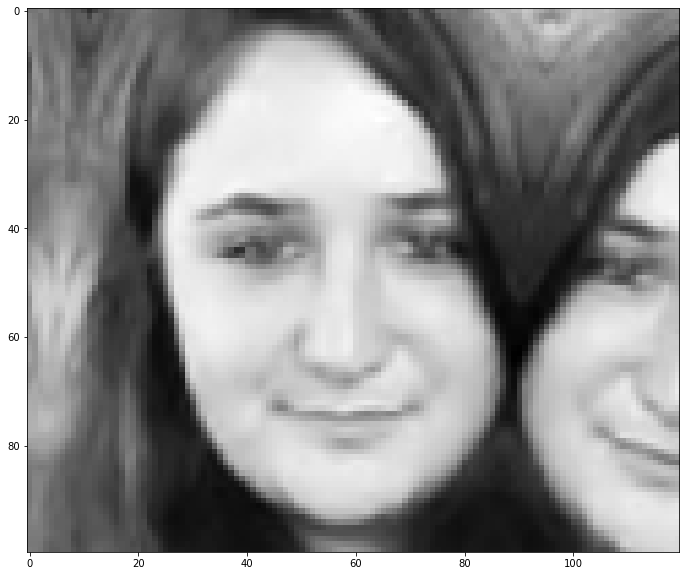

In [ ]:
salah_img = preProcessing(face_image_files[3])

display(salah_img)

In [ ]:
face_position = predic_face(salah_img)

101 121


In [ ]:
HALF_WINDOW = 50
# HALF_WINDOW = WINDOW_SIZE // 2

In [ ]:
def to_image(values: np.ndarray) -> Image.Image:
    return Image.fromarray(np.uint8(values * 255.))

In [ ]:
def render_candidates(image: Image.Image, candidates: List[Tuple[int, int]]) -> Image.Image:
    canvas = to_float_array(image.copy())
    for row, col in candidates:
        canvas[row-HALF_WINDOW-1:row+HALF_WINDOW, col-HALF_WINDOW-1, :] = [1., 0., 0.]
        canvas[row-HALF_WINDOW-1:row+HALF_WINDOW, col+HALF_WINDOW-1, :] = [1., 0., 0.]
        canvas[row-HALF_WINDOW-1, col-HALF_WINDOW-1:col+HALF_WINDOW, :] = [1., 0., 0.]
        canvas[row+HALF_WINDOW-1, col-HALF_WINDOW-1:col+HALF_WINDOW, :] = [1., 0., 0.]
    return to_image(canvas)

In [ ]:
# import numpy as np

# def non_maximum_supression(regions,half_window,threshold=0.5,):
#     # Code from: https://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
#     # if there are no boxes, return an empty list
#     boxes = np.array(regions)
#     if len(boxes) == 0:
#         return []

#     # if the bounding boxes integers, convert them to floats --
#     # this is important since we'll be doing a bunch of divisions
#     if boxes.dtype.kind == "i":
#         boxes = boxes.astype("float")

#     # initialize the list of picked indexes
#     pick = []

#     # grab the coordinates of the bounding boxes
#     x1 = boxes[:, 0]-half_window-1
#     y1 = boxes[:, 1]-half_window-1
#     x2 = boxes[:, 0]+half_window
#     y2 = boxes[:, 1]+half_window

#     # compute the area of the bounding boxes and sort the bounding
#     # boxes by the bottom-right y-coordinate of the bounding box
#     area = (x2 - x1 + 1) * (y2 - y1 + 1)
#     idxs = np.argsort(y2)

#     # keep looping while some indexes still remain in the indexes
#     # list
#     while len(idxs) > 0:
#         # grab the last index in the indexes list and add the
#         # index value to the list of picked indexes
#         last = len(idxs) - 1
#         i = idxs[last]
#         pick.append(i)

#         # find the largest (x, y) coordinates for the start of
#         # the bounding box and the smallest (x, y) coordinates
#         # for the end of the bounding box
#         xx1 = np.maximum(x1[i], x1[idxs[:last]])
#         yy1 = np.maximum(y1[i], y1[idxs[:last]])
#         xx2 = np.minimum(x2[i], x2[idxs[:last]])
#         yy2 = np.minimum(y2[i], y2[idxs[:last]])

#         # compute the width and height of the bounding box
#         w = np.maximum(0, xx2 - xx1 + 1)
#         h = np.maximum(0, yy2 - yy1 + 1)

#         # compute the ratio of overlap
#         overlap = (w * h) / area[idxs[:last]]

#         # delete all indexes from the index list that have
#         idxs = np.delete(idxs, np.concatenate(([last],
#                                                np.where(overlap > threshold)[0])))

#     # return only the bounding boxes that were picked using the
#     # integer data type
#     return boxes[pick].astype("int")

In [ ]:
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

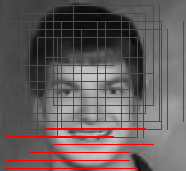

In [ ]:
#def non_maximum_supression(regions,half_window,threshold=0.5,):
test_img = cv2.imread(face_image_files[5], cv2.IMREAD_COLOR)
# face_position=non_maximum_supression(face_position,HALF_WINDOW,0.5)
face_position= non_maximum_supression(face_position,0.3)
render_candidates(test_img, face_position)